# Option implied probability density surface

In [1]:
# Setup for the notebook
from typing import List, Tuple
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline, CloughTocher2DInterpolator
from matplotlib import cbook, cm
from matplotlib.colors import LightSource

# plt.style.use('ggplot')
plt.style.use("seaborn-v0_8-whitegrid")
project_root = Path(os.path.abspath(""))

from quantform.pylib import QfDate
from quantform.pylib.equity.utils import parse_option_id, form_option_id
from quantform.pylib.equity.derivative import Option
from quantform.pylib.curve import ImpliedVolatilityCurve, DiscountCurve
from quantform.pylib.equity.pricer import PathIndependentBreedenLitzenbergerPricer

## Yield curves

In [2]:
yield_250815_df = pd.read_csv(project_root / "example_data" / "Treasury_Yields_2025-08-15.csv", sep=',')
yield_250815_curve = DiscountCurve(yield_250815_df["TTM (Years)"], yield_250815_df["Yield (%)"] / 100)

In [3]:
yield_251114_df = pd.read_csv(project_root / "example_data" / "Treasury_Yields_2025-11-14.csv", sep=',')
yield_251114_curve = DiscountCurve(yield_251114_df["TTM (Years)"], yield_251114_df["Yield (%)"] / 100)

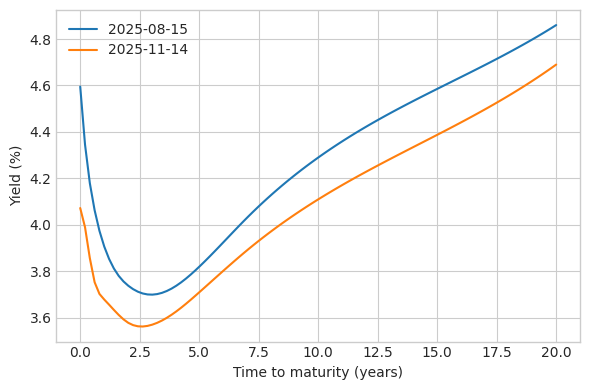

In [4]:
fig = plt.figure(figsize=(6, 4))

xx = np.linspace(0, 20, 100)
yy_250815 = [yield_250815_curve(x) * 100 for x in xx]
yy_251114 = [yield_251114_curve(x) * 100 for x in xx]

plt.plot(xx, yy_250815, label="2025-08-15")
plt.plot(xx, yy_251114, label="2025-11-14")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Yield (%)")

fig.tight_layout()
plt.legend()
plt.show()

## Implied volatility curves

In [5]:
start_date  = QfDate(2025, 8, 15, calendar="NYSE", convention="Business/252")
update_date = QfDate(2025, 11, 14, calendar="NYSE", convention="Business/252")
end_date    = QfDate(2026, 12, 18, calendar="NYSE", convention="Business/252")
# Subtract a tiny amount to make the volatilities easier to calculate
underlying_start_value  = 640  # Exact price 642.52 USD
underlying_update_value = 670  # Exact price 671.93 USD

In [6]:
option_250815_df = pd.read_csv(project_root / "example_data" / "SPY_Calls_2025-08-15.tsv", sep='\t')
option_251114_df = pd.read_csv(project_root / "example_data" / "SPY_Calls_2025-11-14.tsv", sep='\t')

In [7]:
# Function that creates an Option object from the given option price data. If the implied volatility cannot be calculated skips the option
def to_option(row: pd.Series, report_date: QfDate, underlying_value: float, yield_curve: DiscountCurve) -> Option:
  # If the implied volatility is marked as zero in Yahoo Finance it most likely cannot be calculated
  if row["Implied Volatility"] == "0.00%":
    # print(f"Invalid implied volatility with option {row["Contract Name"]}!")
    return
  try:
    option_params = parse_option_id(row["Contract Name"], calendar="NYSE")
    return Option(row["Contract Name"], *option_params, risk_free_rate=yield_curve(report_date.timedelta(option_params[1])), 
                  market_price=(row["Bid"] + row["Ask"]) / 2, underlying_value=underlying_value, report_date=report_date)
  except AssertionError as e:
    # print(f"Not able to calculate the implied volatility for option {row["Contract Name"]}! ({e})")
    return 

In [8]:
# Note that calculating the implied volatilities for thousands of options is quite computationally expensive.
# However, as going forward the same underlying values and report dates will be used, it is enough to do this just once
options_250815 = [to_option(row, start_date, underlying_start_value, yield_250815_curve) for _, row in option_250815_df.iterrows()]
options_250815 = [option for option in options_250815 if option is not None]
all_options_250815 = options_250815
print("Number of valid options for 2025-08-15:", len(options_250815))
options_251114 = [to_option(row, update_date, underlying_update_value, yield_251114_curve) for _, row in option_251114_df.iterrows()]
options_251114 = [option for option in options_251114 if option is not None]
print("Number of valid options for 2025-11-14:", len(options_251114))
all_options_251114 = options_251114

Number of valid options for 2025-08-15: 2883
Number of valid options for 2025-11-14: 3581


In [9]:
# Additional cleanup of the options might be required. So go over the options and drop the
# ones for which the calculated implied volatility differs significantly from it's neighbors
# Also maturity dates with too small range of strikes is removed here
def option_cleanup(options: List[Option], required_strike_range: Tuple[float]) -> List[Option]:
  distinct_maturity_dates = list(set([option.maturity_date for option in options]))
  distinct_maturity_dates.sort()

  valid_options = []

  for maturity_date in distinct_maturity_dates:
    maturity_date_options = [option for option in options if option.maturity_date == maturity_date]
    maturity_date_options.sort()
    valid_maturity_date_options = []
    max_strike = 0
    min_strike = float('inf')
    
    for i, option in enumerate(maturity_date_options):
      
      if (i == 0) or (i == len(maturity_date_options) - 1):
        valid_maturity_date_options.append(option)
        continue
      
      expected_vol = (maturity_date_options[i - 1].pricer.volatility + maturity_date_options[i + 1].pricer.volatility) / 2
      
      if abs(expected_vol - option.pricer.volatility) < 0.01:
        valid_maturity_date_options.append(option)
        
        if option.strike > max_strike:
          max_strike = option.strike
        if option.strike < min_strike:
          min_strike = option.strike
          
      else:
        pass
    
    if (min_strike <= required_strike_range[0]) and (max_strike >= required_strike_range[1]):
      valid_options += valid_maturity_date_options
    
  return valid_options

In [10]:
options_250815 = option_cleanup(options_250815, (450, 700))
print("Remaining options 2025-08-15:", len(options_250815))
options_251114 = option_cleanup(options_251114, (450, 700))
print("Remaining options 2025-11-14:", len(options_251114))

Remaining options 2025-08-15: 2089
Remaining options 2025-11-14: 2279


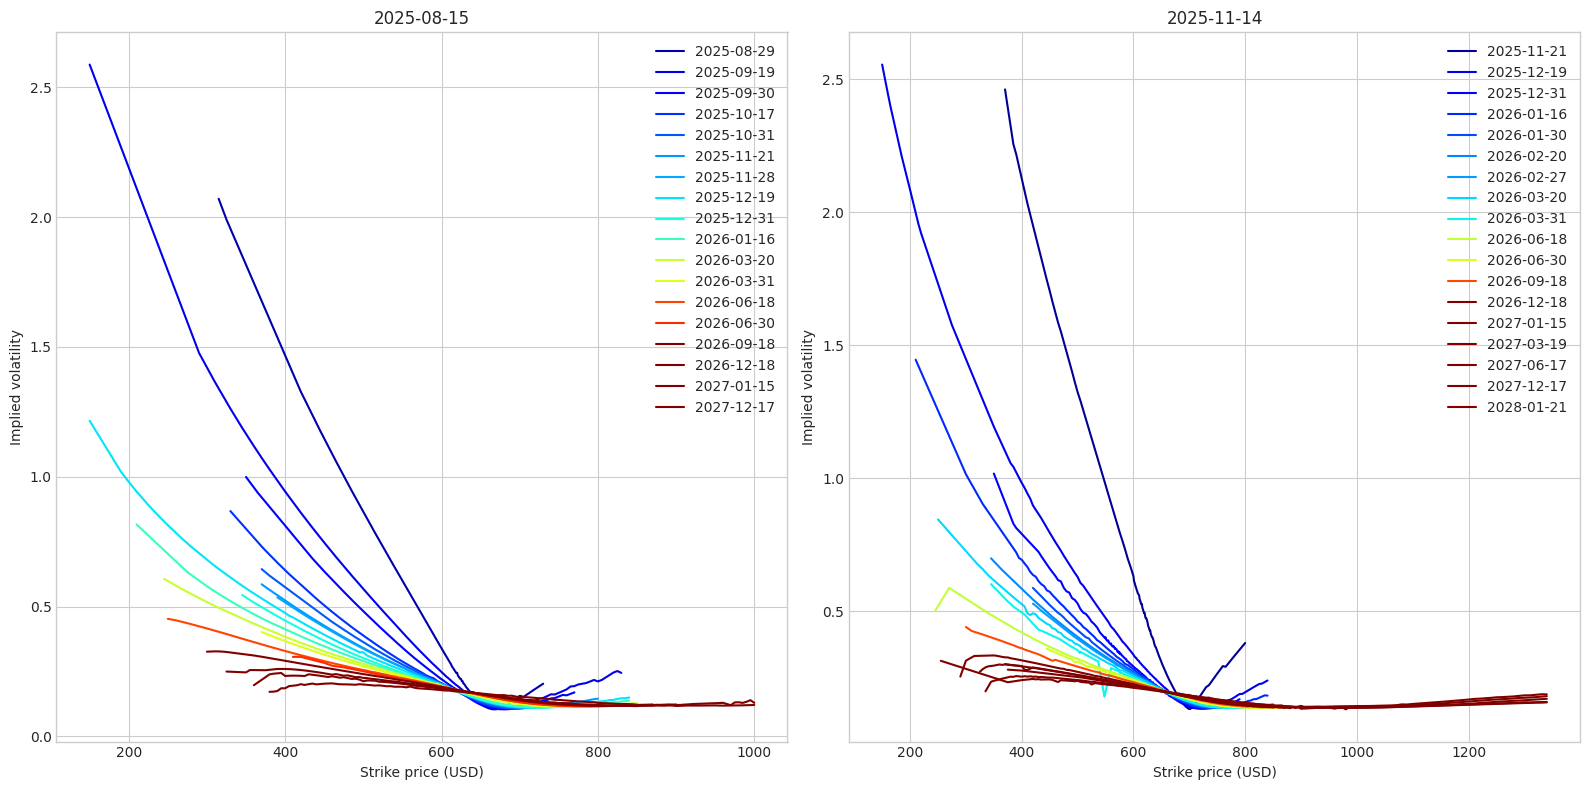

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

option_tups = [(start_date, options_250815), (update_date, options_251114)]

for i, (report_date, options) in enumerate(option_tups):
  distinct_maturity_dates = list(set([option.maturity_date for option in options]))
  distinct_maturity_dates.sort()

  taus = np.array([report_date.timedelta(maturity_date) for maturity_date in distinct_maturity_dates])

  axs[i].set_prop_cycle(plt.cycler('color', plt.cm.jet(taus)))

  for maturity_date in distinct_maturity_dates:
    maturity_date_options = [option for option in options if option.maturity_date == maturity_date]
    maturity_date_vols    = [option.pricer.volatility for option in maturity_date_options]
    maturity_date_strikes = [option.strike for option in maturity_date_options]
    
    axs[i].plot(maturity_date_strikes, maturity_date_vols, label=str(maturity_date))
    
  axs[i].legend()
  axs[i].set_title(str(report_date))
  axs[i].set_xlabel("Strike price (USD)")
  axs[i].set_ylabel("Implied volatility")

fig.tight_layout()
plt.show()

In [12]:
# Remove some problematic looking curves
options_251114 = [option for option in options_251114 if option.maturity_date not in [QfDate(2026, 3, 31, calendar="NYSE")]]

## Implied volatility surface

In [13]:
tuples = [(underlying_start_value, start_date, options_250815), (underlying_update_value, update_date, options_251114)]
volatility_surfaces = {}

for underlying_value, report_date, options in tuples:
  strikes    = np.linspace(0, 1500, 100)
  vol_values = {} 
  
  distinct_maturity_dates = list(set([option.maturity_date for option in options]))
  distinct_maturity_dates.sort()

  for i, maturity_date in enumerate(distinct_maturity_dates):
    if (maturity_date == QfDate(2026, 12, 18, calendar="NYSE")) or (i == 0):
      print(f"Tau for report date {report_date} and maturity date {maturity_date}: {report_date.timedelta(maturity_date)}")
    
    maturity_date_options = [option for option in options if (option.maturity_date == maturity_date) and (option.strike >= 400) and (option.strike <= 700)]
    curve = ImpliedVolatilityCurve(maturity_date_options, underlying_value, report_date)
    
    vols = []
    for strike in strikes:
      vols.append(curve(strike))
      
    vol_values[maturity_date] = vols
    
  maturity_taus = np.array([report_date.timedelta(maturity_date) for maturity_date in distinct_maturity_dates])
  taus = np.linspace(maturity_taus[0], maturity_taus[-1], 100)

  values = []
  points = []

  for i in range(len(strikes)):
    vols  = [vol_values[maturity_date][i] for maturity_date in distinct_maturity_dates]
    curve = CubicSpline(maturity_taus, vols)
    
    for tau in taus:
      points.append((strikes[i], tau))
      values.append(curve(tau))
    
  volatility_surfaces[report_date] = CloughTocher2DInterpolator(points, values)

Tau for report date 2025-08-15 and maturity date 2025-08-29: 0.03968253968253968
Tau for report date 2025-08-15 and maturity date 2026-12-18: 1.3412698412698412
Tau for report date 2025-11-14 and maturity date 2025-11-21: 0.01984126984126984
Tau for report date 2025-11-14 and maturity date 2026-12-18: 1.0873015873015872


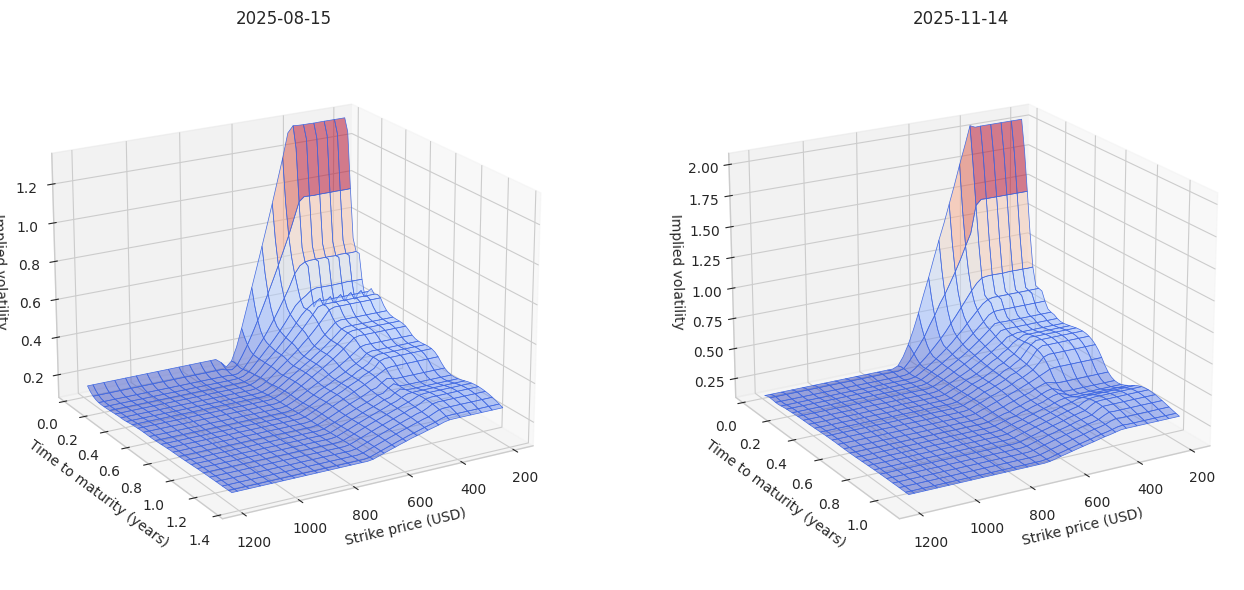

In [14]:
n_discr     = 50
strikes     = np.linspace(200, 1200, n_discr)
taus_250815 = np.linspace(0.04, 1.341, n_discr)
taus_251114 = np.linspace(0.02, 1.087, n_discr)
tau_map = {start_date: taus_250815, update_date: taus_251114}

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection='3d'))

for i, report_date in enumerate([start_date, update_date]):
  
  x, y = np.meshgrid(strikes, tau_map[report_date])
  z = volatility_surfaces[report_date](x, y)

  surf = axs[i].plot_surface(x, y, z, cmap="coolwarm", edgecolor='royalblue', lw=0.5, rstride=round(n_discr / 20), cstride=round(n_discr / 20), alpha=0.5)

  axs[i].view_init(elev=20, azim=60)
  axs[i].set_title(report_date)
  axs[i].set_zlabel("Implied volatility")
  axs[i].set_ylabel("Time to maturity (years)")
  axs[i].set_xlabel("Strike price (USD)")

fig.tight_layout()
fig.savefig(project_root / "figures" / "volatility_surfaces.pdf")
plt.show()

## Probability density surface

In [15]:
tuples = [(underlying_start_value, start_date, yield_250815_curve, volatility_surfaces[start_date], taus_250815), (underlying_update_value, update_date, yield_251114_curve, volatility_surfaces[update_date], taus_251114)]
pdf_surfaces    = {}
expected_values = {start_date: [], update_date: []}
variances       = {start_date: [], update_date: []}

for underlying_value, report_date, yield_curve, volatility_surface, taus in tuples:

  points     = []
  values     = []
  exp_values = []

  for i, tau in enumerate(taus):
    print(f"Progress: {i + 1} / {len(taus)}")
    
    maturity_date  = report_date * tau
    treasury_yield = yield_curve(tau)
    vol_curve = CubicSpline(strikes, volatility_surface([(strike, tau) for strike in strikes]))
    
    bl_pricer = PathIndependentBreedenLitzenbergerPricer(maturity_date, lambda x: x, vol_curve, treasury_yield)
    pdf_curve = bl_pricer.implied_density(underlying_value, report_date, (0, 1500))
    
    expected_values[report_date].append(pdf_curve.mean)
    variances[report_date].append(pdf_curve.variance)
    
    for strike in strikes:
      points.append((strike, tau))
      values.append(pdf_curve(strike))
      
  pdf_surfaces[report_date] = CloughTocher2DInterpolator(points, values)

Progress: 1 / 50
Progress: 2 / 50
Progress: 3 / 50
Progress: 4 / 50
Progress: 5 / 50
Progress: 6 / 50
Progress: 7 / 50
Progress: 8 / 50
Progress: 9 / 50
Progress: 10 / 50
Progress: 11 / 50
Progress: 12 / 50
Progress: 13 / 50
Progress: 14 / 50
Progress: 15 / 50
Progress: 16 / 50
Progress: 17 / 50
Progress: 18 / 50
Progress: 19 / 50
Progress: 20 / 50
Progress: 21 / 50
Progress: 22 / 50
Progress: 23 / 50
Progress: 24 / 50
Progress: 25 / 50
Progress: 26 / 50
Progress: 27 / 50
Progress: 28 / 50
Progress: 29 / 50
Progress: 30 / 50
Progress: 31 / 50
Progress: 32 / 50
Progress: 33 / 50
Progress: 34 / 50
Progress: 35 / 50
Progress: 36 / 50
Progress: 37 / 50
Progress: 38 / 50
Progress: 39 / 50
Progress: 40 / 50
Progress: 41 / 50
Progress: 42 / 50
Progress: 43 / 50
Progress: 44 / 50
Progress: 45 / 50
Progress: 46 / 50
Progress: 47 / 50
Progress: 48 / 50
Progress: 49 / 50
Progress: 50 / 50
Progress: 1 / 50
Progress: 2 / 50
Progress: 3 / 50
Progress: 4 / 50
Progress: 5 / 50
Progress: 6 / 50
Progres

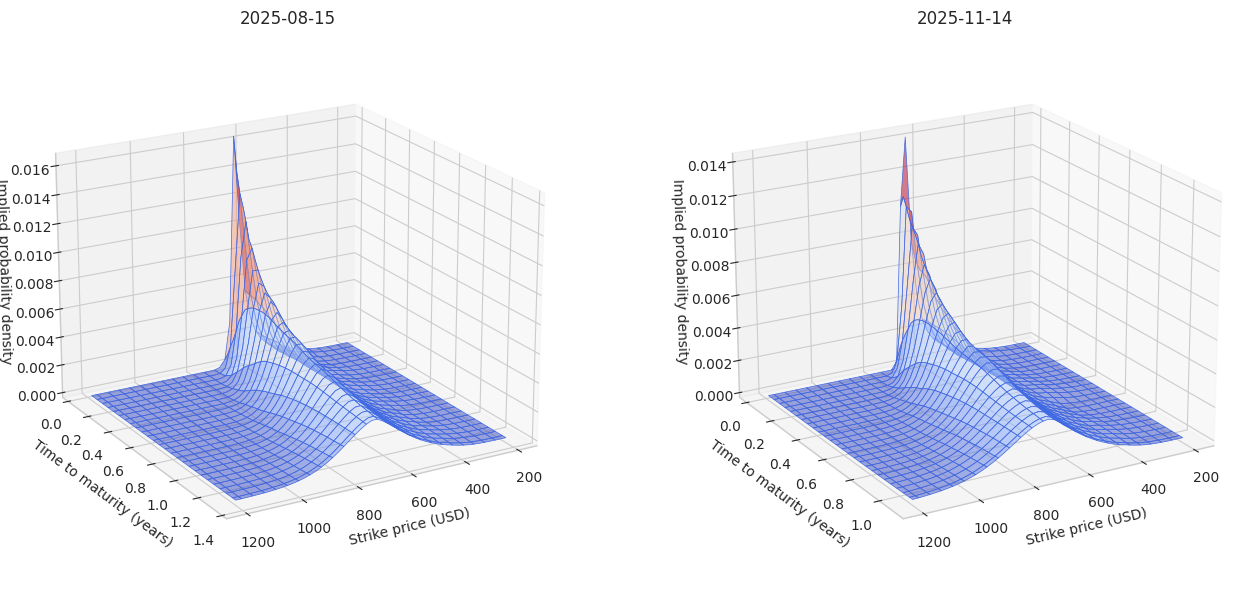

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection='3d'))

for i, report_date in enumerate([start_date, update_date]):
  x, y = np.meshgrid(strikes, tau_map[report_date])
  z = pdf_surfaces[report_date](x, y)

  surf = axs[i].plot_surface(x, y, z, cmap="coolwarm", edgecolor='royalblue', lw=0.5, rstride=round(n_discr / 20), cstride=round(n_discr / 20), alpha=0.5)

  axs[i].view_init(elev=20, azim=60)
  axs[i].set_title(report_date)
  axs[i].set_zlabel("Implied probability density")
  axs[i].set_ylabel("Time to maturity (years)")
  axs[i].set_xlabel("Strike price (USD)")

fig.tight_layout()
fig.savefig(project_root / "figures" / "pdf_surfaces.pdf")
plt.show()

## Evaluation of forward looking densities

In [17]:
history_df = pd.read_csv(project_root / "example_data" / "SPY_Historical_2025-11-14.csv")
history_df = history_df.query("Date >= '2024-12-18'").loc[::-1]  # Reverses the dataframe

In [18]:
history_values = history_df["Close"].to_numpy()
history_taus   = []

for date in history_df["Date"]:
  year, month, day = map(int, date.split('-'))
  qf_date = QfDate(year, month, day, calendar="NYSE")
  history_taus.append(start_date.timedelta(qf_date))
  
history_taus = np.array(history_taus)

Correction sizes: 2025-08-15 -> 33.22503008297349 | 2025-11-14 -> 37.57719465996229


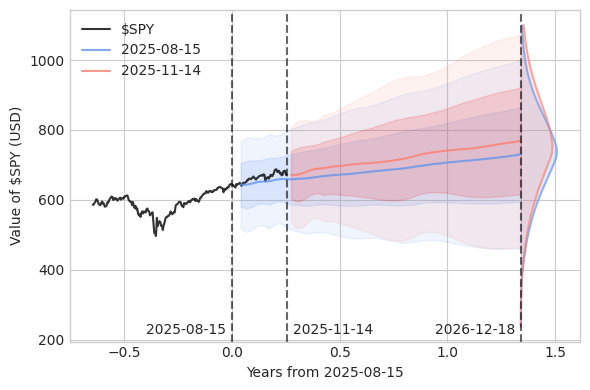

In [ ]:
# Due to an issue with the expected value calculation, correct the expected values to start at the start and end of the realized time series respectively
# Additionally, clean up the expected values for date 2025-08-15 as the first three expectations are too varied
exp_values_250815 = np.array(expected_values[start_date])
std_values_250815 = np.array([np.sqrt(var) for var in variances[start_date]])
correction_250815 = history_values[-65] - exp_values_250815[0]
exp_values_250815 = exp_values_250815 + correction_250815
exp_taus_250815   = np.array(taus_250815)

exp_values_251114 = np.array(expected_values[update_date])
std_values_251114 = np.array([np.sqrt(var) for var in variances[update_date]])
correction_251114 = history_values[-1] - exp_values_251114[0]
exp_values_251114 = exp_values_251114 + correction_251114
exp_taus_251114   = np.array(taus_251114) + start_date.timedelta(update_date)

print(f"Correction sizes: 2025-08-15 -> {correction_250815} | 2025-11-14 -> {correction_251114}")

# Plot the time-series
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(history_taus, history_values, color='black', alpha=0.8, label="$SPY")
plt.plot(exp_taus_250815, exp_values_250815, color='cornflowerblue', alpha=0.8, label="2025-08-15")
plt.plot(exp_taus_251114, exp_values_251114, color='salmon', alpha=0.8, label="2025-11-14")

plt.fill_between(exp_taus_250815, exp_values_250815 - std_values_250815, exp_values_250815 + std_values_250815, color='cornflowerblue', alpha=0.15)
plt.fill_between(exp_taus_251114, exp_values_251114 - std_values_251114, exp_values_251114 + std_values_251114, color='red', alpha=0.15)
plt.fill_between(exp_taus_250815, exp_values_250815 - std_values_250815 * 2, exp_values_250815 + std_values_250815 * 2, color='cornflowerblue', alpha=0.1)
plt.fill_between(exp_taus_251114, exp_values_251114 - std_values_251114 * 2, exp_values_251114 + std_values_251114 * 2, color='salmon', alpha=0.1)

strikes = np.linspace(0, 1100, 1000)
end_pdf_values_250815 = pdf_surfaces[start_date](strikes - correction_251114, np.array([1.341] * 1000)) * 50
end_pdf_values_251114 = pdf_surfaces[update_date](strikes - correction_251114, np.array([1.087] * 1000)) * 50

plt.plot(1.341 + end_pdf_values_250815, strikes, color="cornflowerblue", alpha=0.8)
plt.plot(1.341 + end_pdf_values_251114, strikes, color="salmon", alpha=0.8)

ax.fill_betweenx(strikes, np.array([1.341] * 1000), 1.341 + end_pdf_values_250815, color='cornflowerblue', alpha=0.2)
ax.fill_betweenx(strikes, np.array([1.341] * 1000), 1.341 + end_pdf_values_251114, color='salmon', alpha=0.2)

plt.xlabel(f"Years from {start_date}")
plt.ylabel(f"Value of $SPY (USD)")
plt.legend()

plt.axvline(0.0, color='black', linestyle='dashed', alpha=0.8)
ax.text(0.0 - 0.4, 215, "2025-08-15", fontsize=10)

plt.axvline(start_date.timedelta(update_date), color='black', linestyle='dashed', alpha=0.8)
ax.text(start_date.timedelta(update_date) + 0.03, 215, "2025-11-14", fontsize=10)

plt.axvline(1.341, color='black', linestyle='dashed', alpha=0.8)
ax.text(1.341 - 0.4, 215, "2026-12-18", fontsize=10)

fig.tight_layout()
fig.savefig(project_root / "figures" / "expected_time-series.pdf")
plt.show()

In [38]:
exp_interp_250815 = CubicSpline(exp_taus_250815, exp_values_250815)
std_interp_250815 = CubicSpline(exp_taus_250815, std_values_250815)
exp_interp_251114 = CubicSpline(exp_taus_251114, exp_values_251114)

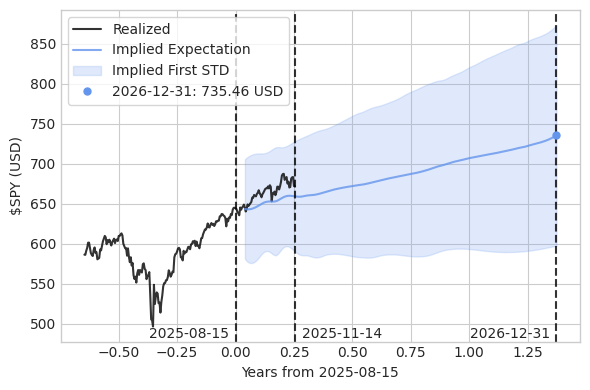

In [50]:
# Plot the time-series and the final distributions in separate figures
fig, ax = plt.subplots(figsize=(6, 4))

t_261231 = start_date.timedelta(QfDate(2026, 12, 31, calendar="NYSE"))

tt = np.linspace(0.04, t_261231, 1000)
exp_tt_250815 = exp_interp_250815(tt)
std_tt_250815 = std_interp_250815(tt)

plt.plot(history_taus, history_values, color='black', alpha=0.8, label="Realized")
plt.plot(tt, exp_tt_250815, color='cornflowerblue', alpha=0.8, label="Implied Expectation")

plt.fill_between(tt, exp_tt_250815 - std_tt_250815, exp_tt_250815 + std_tt_250815, color='cornflowerblue', alpha=0.2, label="Implied First STD")

plt.axvline(0.0, color='black', linestyle='dashed', alpha=0.8)
ax.text(0.0 - 0.37, 482, "2025-08-15", fontsize=10)

plt.axvline(start_date.timedelta(update_date), color='black', linestyle='dashed', alpha=0.8)
ax.text(start_date.timedelta(update_date) + 0.03, 482, "2025-11-14", fontsize=10)

plt.axvline(t_261231, color='black', linestyle='dashed', alpha=0.8)
ax.text(t_261231 - 0.37, 482, "2026-12-31", fontsize=10)

plt.plot([t_261231], [exp_interp_250815(t_261231)], color="cornflowerblue", linestyle='None', marker='o', markersize=5, label=f"2026-12-31: {exp_interp_250815(t_261231):.2f} USD")

plt.xlabel(f"Years from {start_date}")
plt.ylabel(f"$SPY (USD)")
plt.legend(frameon=True, fancybox=True)

fig.tight_layout()
fig.savefig(project_root / "figures" / "implied_time-series.png")
plt.show()

In [22]:
expectation_251114 = exp_interp_250815(start_date.timedelta(update_date))
print(f"Expected value for 2025-11-14: {expectation_251114}")
print(f"Change: {((expectation_251114 / 642.52) * 100 - 100):.2f}")

Expected value for 2025-11-14: 659.1952309031349
Change: 2.60


In [23]:
expectation_251231 = exp_interp_250815(start_date.timedelta(QfDate(2025, 12, 31, calendar="NYSE")))
print(f"Expected value for 2025-12-31: {expectation_251231}")
print(f"Change: {((expectation_251231 / 642.52) * 100 - 100):.2f}")

Expected value for 2025-12-31: 664.0668875090936
Change: 3.35


In [24]:
expectation_update_251231 = exp_interp_251114(start_date.timedelta(QfDate(2025, 12, 31, calendar="NYSE")))
print(f"Updated expected value for 2025-12-31: {expectation_update_251231}")
print(f"Change: {((expectation_update_251231 / 642.52) * 100 - 100):.2f}")

Updated expected value for 2025-12-31: 687.3109329620343
Change: 6.97


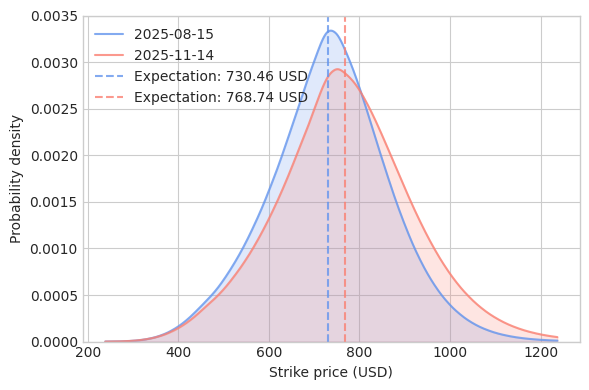

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

strikes = np.linspace(0, 1500, 1000)
end_pdf_values_250815 = pdf_surfaces[start_date](strikes - correction_251114, np.array([1.341] * 1000))
end_pdf_values_251114 = pdf_surfaces[update_date](strikes - correction_251114, np.array([1.087] * 1000))

plt.plot(strikes, end_pdf_values_250815, color='cornflowerblue', alpha=0.8, label="2025-08-15")
plt.plot(strikes, end_pdf_values_251114, color='salmon', alpha=0.8, label="2025-11-14")

ax.fill_between(strikes, [0] * len(strikes), end_pdf_values_250815, color='cornflowerblue', alpha=0.2)
ax.fill_between(strikes, [0] * len(strikes), end_pdf_values_251114, color='salmon', alpha=0.2)

plt.axvline(exp_interp_250815(start_date.timedelta(QfDate(2026, 12, 18, calendar="NYSE"))), color='cornflowerblue', linestyle='dashed', alpha=0.8, label=f"Expectation: {exp_interp_250815(start_date.timedelta(QfDate(2026, 12, 18, calendar="NYSE"))):.2f} USD")
plt.axvline(exp_interp_251114(start_date.timedelta(QfDate(2026, 12, 18, calendar="NYSE"))), color='salmon', linestyle='dashed', alpha=0.8, label=f"Expectation: {exp_interp_251114(start_date.timedelta(QfDate(2026, 12, 18, calendar="NYSE"))):.2f} USD")

plt.xlabel(f"$SPY (USD)")
plt.ylabel(f"Probability density")
plt.legend()

plt.ylim(0, 0.0035)

fig.tight_layout()
fig.savefig(project_root / "figures" / "densities_2026-12-18.png")
plt.show()

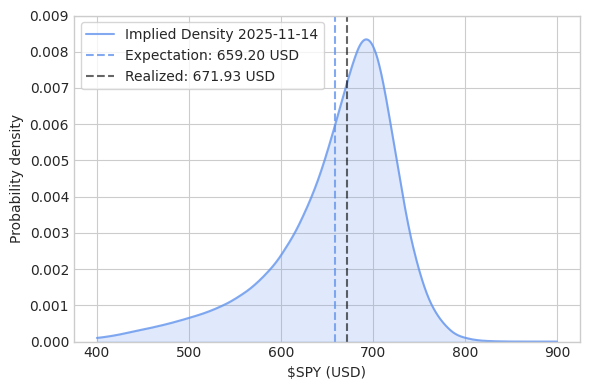

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))

strikes = np.linspace(400, 900, 1000)
pdf_values_251114 = pdf_surfaces[start_date](strikes - correction_250815, np.array([start_date.timedelta(update_date)] * 1000))

# plt.plot(strikes, end_pdf_values_250815, color='blue', alpha=0.5, label="2025-08-15")
plt.plot(strikes, pdf_values_251114, color='cornflowerblue', alpha=0.8, label="Implied Density 2025-11-14")

# ax.fill_between(strikes, [0] * len(strikes), end_pdf_values_250815, color='blue', alpha=0.2)
ax.fill_between(strikes, [0] * len(strikes), pdf_values_251114, color='cornflowerblue', alpha=0.2)

plt.axvline(exp_interp_250815(start_date.timedelta(update_date)), color='cornflowerblue', linestyle='dashed', alpha=0.8, label=f"Expectation: {exp_interp_250815(start_date.timedelta(update_date)):.2f} USD")
plt.axvline(671.93, color='black', linestyle='dashed', alpha=0.6, label=f"Realized: 671.93 USD")
# plt.axvline(exp_interp_251114(start_date.timedelta(QfDate(2026, 12, 18, calendar="NYSE"))), color='red', linestyle='dashed', alpha=0.6, label=f"Expectation: {exp_interp_251114(start_date.timedelta(QfDate(2026, 12, 18, calendar="NYSE"))):.2f} USD")

plt.xlabel(f"$SPY (USD)")
plt.ylabel(f"Probability density")
plt.legend(frameon=True, fancybox=True)

plt.ylim(0, 0.009)

fig.tight_layout()
fig.savefig(project_root / "figures" / "implied_density_2025-11-14.png")
plt.show()